<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU/GRU_Treasury10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 119 (delta 53), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (119/119), 107.55 KiB | 4.30 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 13 15:47:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Treasury10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 8.5MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 174kB 38.3MB/s 
     |████████████████████████████████| 143kB 38.4MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # input layer
    model.add(GRU(units=config.input_size,
                  activation=config.activation,
                  return_sequences=True,
                  input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # hidden layer
    model.add(GRU(units=config.hidden_size))
    model.add(Dropout(config.dropout))
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_GRU')

Create sweep with ID: htfcfvq8
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU/sweeps/htfcfvq8


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_GRU')

wandb: Agent Starting Run: 1cvg3f0c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 27s 106ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - mean_absolute_error: 0.2880 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0731
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1141 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1023
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0950 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0627
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0867 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0550
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0096 - mean_square

epoch,99
loss,0.00243
mean_squared_error,0.00243
mean_absolute_error,0.03808
val_loss,0.00192
val_mean_squared_error,0.00192
val_mean_absolute_error,0.03486
_runtime,60
_timestamp,1626191341
_step,99
best_val_loss,0.00192


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▃▃▃▃▄▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▃▃▃▃▄▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▄▃▃▄▃▄▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6umzcx3v with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 15s 155ms/step - loss: 0.2383 - mean_squared_error: 0.2383 - mean_absolute_error: 0.4016 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1189
Epoch 2/50
32/32 [==============================] - 4s 111ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1503 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1344
Epoch 3/50
32/32 [==============================] - 4s 114ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1244 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1197
Epoch 4/50
32/32 [==============================] - 4s 113ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1179 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1087
Epoch 5/50
32/32 [==============================] - 4s 116ms/step - loss: 0.0177 - mean_squared

epoch,39
loss,0.00483
mean_squared_error,0.00483
mean_absolute_error,0.05503
val_loss,0.00422
val_mean_squared_error,0.00422
val_mean_absolute_error,0.05109
_runtime,162
_timestamp,1626191510
_step,39
best_val_loss,0.00408


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nke4zpmc with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 10s 154ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1510 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0507
Epoch 2/200
32/32 [==============================] - 4s 116ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0769 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0481
Epoch 3/200
32/32 [==============================] - 4s 110ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0712 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0454
Epoch 4/200
32/32 [==============================] - 4s 113ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0648 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0464
Epoch 5/200
32/32 [==============================] - 4s 113ms/step - loss: 0.0071 - mean_sq

epoch,96
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.02987
val_loss,0.00167
val_mean_squared_error,0.00167
val_mean_absolute_error,0.03139
_runtime,377
_timestamp,1626191895
_step,96
best_val_loss,0.00163


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▅▄▃▅▃▂▃▄▂▆▃▂▁▃▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▅▄▃▅▃▂▃▄▂▆▃▂▁▃▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▅▄▆▃▃▃▄▂▇▄▂▂▃▂▂▂▂▁▂▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1ms7u7d6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 285ms/step - loss: 0.1045 - mean_squared_error: 0.1045 - mean_absolute_error: 0.2426 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1798
Epoch 2/50
8/8 [==============================] - 1s 122ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1058 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0627
Epoch 3/50
8/8 [==============================] - 1s 119ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0623
Epoch 4/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0949 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.1005
Epoch 5/50
8/8 [==============================] - 1s 126ms/step - loss: 0.0082 - mean_squared_error: 0.0

epoch,49
loss,0.00243
mean_squared_error,0.00243
mean_absolute_error,0.03853
val_loss,0.00233
val_mean_squared_error,0.00233
val_mean_absolute_error,0.03761
_runtime,67
_timestamp,1626191969
_step,49
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▃▂▁▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▃▂▁▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▄▃▂▃▃▂▂▃▂▂▃▂▃▂▁▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁
val_loss,█▂▂▃▂▁▃▂▁▃▁▃▂▁▁▂▁▁▁▁▁▁▁▁▃▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▂▂▃▂▁▃▂▁▃▁▃▂▁▁▂▁▁▁▁▁▁▁▁▃▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▂▂▄▂▂▄▂▁▄▂▄▂▂▁▂▁▁▁▂▂▁▂▁▄▂▁▃▃▂▁▁▁▁▃▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: s1wkf6bg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 8s 196ms/step - loss: 0.0858 - mean_squared_error: 0.0858 - mean_absolute_error: 0.2260 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 2/100
16/16 [==============================] - 2s 127ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1173 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0954
Epoch 3/100
16/16 [==============================] - 2s 120ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0835 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0497
Epoch 4/100
16/16 [==============================] - 2s 125ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0846 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 5/100
16/16 [==============================] - 2s 118ms/step - loss: 0.0109 - mean_squ

epoch,12
loss,0.00738
mean_squared_error,0.00738
mean_absolute_error,0.06699
val_loss,0.00624
val_mean_squared_error,0.00624
val_mean_absolute_error,0.06228
_runtime,36
_timestamp,1626192013
_step,12
best_val_loss,0.0041


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▃▂▂▂▂▁▁▂▂▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▂▂▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▁▁▁
val_loss,▁█▁▁▄▄▇▃▃▂▂▁▃
val_mean_squared_error,▁█▁▁▄▄▇▃▃▂▂▁▃
val_mean_absolute_error,▁█▁▁▅▄▇▄▃▂▃▁▃
_runtime,▁▂▂▃▃▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: jgnrteep with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 288ms/step - loss: 0.4548 - mean_squared_error: 0.4548 - mean_absolute_error: 0.6286 - val_loss: 0.5114 - val_mean_squared_error: 0.5114 - val_mean_absolute_error: 0.6947
Epoch 2/200
8/8 [==============================] - 1s 122ms/step - loss: 0.2773 - mean_squared_error: 0.2773 - mean_absolute_error: 0.4810 - val_loss: 0.2941 - val_mean_squared_error: 0.2941 - val_mean_absolute_error: 0.5213
Epoch 3/200
8/8 [==============================] - 1s 121ms/step - loss: 0.1517 - mean_squared_error: 0.1517 - mean_absolute_error: 0.3423 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - val_mean_absolute_error: 0.3258
Epoch 4/200
8/8 [==============================] - 1s 126ms/step - loss: 0.0605 - mean_squared_error: 0.0605 - mean_absolute_error: 0.2056 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1555
Epoch 5/200
8/8 [==============================] - 1s 129ms/step - loss: 0.0237 - mean_squared_error

epoch,199
loss,0.0034
mean_squared_error,0.0034
mean_absolute_error,0.04532
val_loss,0.00261
val_mean_squared_error,0.00261
val_mean_absolute_error,0.03988
_runtime,220
_timestamp,1626192240
_step,199
best_val_loss,0.00249


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: th0cs9kh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 7s 183ms/step - loss: 0.1566 - mean_squared_error: 0.1566 - mean_absolute_error: 0.3486 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0910
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0931 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0636
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0867 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0700
Epoch 4/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0793 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0596
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0083 - mean_squared_error: 0.0083 

epoch,49
loss,0.0042
mean_squared_error,0.0042
mean_absolute_error,0.05172
val_loss,0.00421
val_mean_squared_error,0.00421
val_mean_absolute_error,0.05109
_runtime,21
_timestamp,1626192321
_step,49
best_val_loss,0.0034


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▃▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▂▂▃▁
val_mean_squared_error,█▃▄▃▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▂▂▃▁
val_mean_absolute_error,█▄▅▃▂▃▂▂▂▃▃▃▃▂▂▄▂▂▃▂▂▃▂▃▁▁▂▂▁▂▁▁▁▂▁▁▂▂▃▂
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gn5en2lk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 10s 160ms/step - loss: 0.1625 - mean_squared_error: 0.1625 - mean_absolute_error: 0.3506 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1137
Epoch 2/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1482 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1359
Epoch 3/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1430 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1331
Epoch 4/100
32/32 [==============================] - 4s 119ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1330 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1273
Epoch 5/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0243 - mean_sq

epoch,92
loss,0.00481
mean_squared_error,0.00481
mean_absolute_error,0.05491
val_loss,0.00379
val_mean_squared_error,0.00379
val_mean_absolute_error,0.04827
_runtime,372
_timestamp,1626192701
_step,92
best_val_loss,0.00375


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▇▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▇▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fhbgpgpv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 7s 51ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - mean_absolute_error: 0.3297 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0981
Epoch 2/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1483 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1404
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - mean_absolute_error: 0.1293 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1212
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1229 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1179
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0219 - mean_squared_error

epoch,49
loss,0.00399
mean_squared_error,0.00399
mean_absolute_error,0.04908
val_loss,0.00375
val_mean_squared_error,0.00375
val_mean_absolute_error,0.04798
_runtime,33
_timestamp,1626192759
_step,49
best_val_loss,0.00351


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bvoy2pme with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 10s 176ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - mean_absolute_error: 0.2106 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0462
Epoch 2/200
32/32 [==============================] - 4s 120ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0791 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0476
Epoch 3/200
32/32 [==============================] - 4s 127ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0679 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0491
Epoch 4/200
32/32 [==============================] - 4s 125ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0627 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0443
Epoch 5/200
32/32 [==============================] - 4s 122ms/step - loss: 0.0063 - mean_sq

epoch,44
loss,0.00189
mean_squared_error,0.00189
mean_absolute_error,0.03307
val_loss,0.00179
val_mean_squared_error,0.00179
val_mean_absolute_error,0.03266
_runtime,188
_timestamp,1626192956
_step,44
best_val_loss,0.00179


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▆▆▆▅▅▅▄▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▆▁▁▂▁▁▂▁▂▁
val_mean_squared_error,▇▇█▆▆▆▅▅▅▄▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▆▁▁▂▁▁▂▁▂▁
val_mean_absolute_error,▇▇█▆▆▆▆▅▅▅▄▃▃▃▃▄▂▂▂▃▂▂▃▂▂▂▁▃▂▂▆▁▁▂▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rdr0cyt3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 7s 203ms/step - loss: 0.1597 - mean_squared_error: 0.1597 - mean_absolute_error: 0.3583 - val_loss: 0.0720 - val_mean_squared_error: 0.0720 - val_mean_absolute_error: 0.2401
Epoch 2/100
16/16 [==============================] - 2s 123ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1580 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0973
Epoch 3/100
16/16 [==============================] - 2s 114ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1358 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1014
Epoch 4/100
16/16 [==============================] - 2s 123ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1324 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1142
Epoch 5/100
16/16 [==============================] - 2s 119ms/step - loss: 0.0253 - mean_squ

epoch,99
loss,0.00586
mean_squared_error,0.00586
mean_absolute_error,0.05991
val_loss,0.00483
val_mean_squared_error,0.00483
val_mean_absolute_error,0.05504
_runtime,208
_timestamp,1626193172
_step,99
best_val_loss,0.00481


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ql9bpt04 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 11s 159ms/step - loss: 0.1676 - mean_squared_error: 0.1676 - mean_absolute_error: 0.3552 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0758
Epoch 2/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0761 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0620
Epoch 3/100
32/32 [==============================] - 4s 122ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0582 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0619
Epoch 4/100
32/32 [==============================] - 4s 127ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0584
Epoch 5/100
32/32 [==============================] - 4s 128ms/step - loss: 0.0047 - mean_sq

epoch,99
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.03335
val_loss,0.00327
val_mean_squared_error,0.00327
val_mean_absolute_error,0.04457
_runtime,408
_timestamp,1626193592
_step,99
best_val_loss,0.0024


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▅▃▄▃▃▂▂▄▂▃▃▂▂▂▂▂▂▂▁▃▂▁▂▂▁▂▂▁▁▃▁▁▁▁▁▂
val_mean_squared_error,█▅▄▄▅▃▄▃▃▂▂▄▂▃▃▂▂▂▂▂▂▂▁▃▂▁▂▂▁▂▂▁▁▃▁▁▁▁▁▂
val_mean_absolute_error,█▅▅▅▅▄▄▄▃▃▃▅▂▃▃▂▂▂▃▃▂▂▂▃▂▁▃▂▁▂▂▁▁▃▁▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x7ondoy4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 6s 89ms/step - loss: 0.1843 - mean_squared_error: 0.1843 - mean_absolute_error: 0.3578 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1081
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1472 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1245
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1233 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1176
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1077 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0997
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0139 - mean_squared_error

epoch,26
loss,0.00345
mean_squared_error,0.00345
mean_absolute_error,0.04637
val_loss,0.00376
val_mean_squared_error,0.00376
val_mean_absolute_error,0.04799
_runtime,18
_timestamp,1626193665
_step,26
best_val_loss,0.00372


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▇▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▇▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: z8mdhwzz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 6s 49ms/step - loss: 0.2318 - mean_squared_error: 0.2318 - mean_absolute_error: 0.4272 - val_loss: 0.0581 - val_mean_squared_error: 0.0581 - val_mean_absolute_error: 0.1991
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1563 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1328
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1503 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1447
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1429 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1418
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0301 - mean_squared_error

epoch,49
loss,0.00546
mean_squared_error,0.00546
mean_absolute_error,0.05823
val_loss,0.0049
val_mean_squared_error,0.0049
val_mean_absolute_error,0.05482
_runtime,35
_timestamp,1626193709
_step,49
best_val_loss,0.0049


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pc2f5m2s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 7s 55ms/step - loss: 0.0969 - mean_squared_error: 0.0969 - mean_absolute_error: 0.2394 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0608
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0603 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0559
Epoch 3/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0560 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0577
Epoch 4/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0496 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0508
Epoch 5/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03601
val_loss,0.00184
val_mean_squared_error,0.00184
val_mean_absolute_error,0.03386
_runtime,45
_timestamp,1626193784
_step,49
best_val_loss,0.00184


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▆▄▄▄▃▄▅▃▄▃▃▃▂▂▃▄▂▂▂▃▂▂▂▂▂▂▁▁▁▂▃▁▁▂▂▁
val_mean_squared_error,█▆▇▅▆▄▄▄▃▄▅▃▄▃▃▃▂▂▃▄▂▂▂▃▂▂▂▂▂▂▁▁▁▂▃▁▁▂▂▁
val_mean_absolute_error,█▇▇▅▆▅▄▄▄▄▅▄▅▄▄▃▃▂▄▅▂▂▃▃▂▂▃▂▂▂▂▂▁▃▃▂▁▂▃▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: w7fmfv9u with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 10s 159ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1362 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0403
Epoch 2/50
32/32 [==============================] - 4s 124ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0396
Epoch 3/50
32/32 [==============================] - 4s 127ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0402 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0406
Epoch 4/50
32/32 [==============================] - 4s 124ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0420 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0395
Epoch 5/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0024 - mean_squared

epoch,24
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02794
val_loss,0.00265
val_mean_squared_error,0.00265
val_mean_absolute_error,0.04046
_runtime,115
_timestamp,1626193913
_step,24
best_val_loss,0.00187


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▁▁
val_loss,▅▅▅▅▄▄▃▄▂▂█▂▃▂▁▂▂▁▅▁▇▂▂▁▅
val_mean_squared_error,▅▅▅▅▄▄▃▄▂▂█▂▃▂▁▂▂▁▅▁▇▂▂▁▅
val_mean_absolute_error,▅▅▆▅▄▄▃▄▃▂█▂▃▂▁▂▂▁▅▂▇▂▂▁▅
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 3uyvlws2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 10s 162ms/step - loss: 0.1328 - mean_squared_error: 0.1328 - mean_absolute_error: 0.2930 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0581
Epoch 2/50
32/32 [==============================] - 4s 127ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0743 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0487
Epoch 3/50
32/32 [==============================] - 4s 125ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0601 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0467
Epoch 4/50
32/32 [==============================] - 4s 126ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0585 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0513
Epoch 5/50
32/32 [==============================] - 4s 126ms/step - loss: 0.0062 - mean_squared

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
best_config = {
        'epochs': 200,
        'batch_size': 32,
        'dropout': 0.4,
        'input_size': 100,
        'hidden_size': 50,
        'learning_rate': 0.001,
        'optimizer': 'adam',
        'activation': 'selu',
    }

In [16]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(GRU(units=100, return_sequences=True, input_shape=(window_len, 1), activation='selu'))
model.add(Dropout(0.4))
# hidden layer
model.add(GRU(units=50))
model.add(Dropout(0.4))
model.add(Dense(units=1))

# defining the optimiser
optimizer = keras.optimizers.Nadam(learning_rate=0.001)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  53751


In [17]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
40/40 [==============================] - 8s 96ms/step - loss: 0.0594
Epoch 2/200
40/40 [==============================] - 4s 97ms/step - loss: 0.0108
Epoch 3/200
40/40 [==============================] - 4s 96ms/step - loss: 0.0086
Epoch 4/200
40/40 [==============================] - 4s 98ms/step - loss: 0.0086
Epoch 5/200
40/40 [==============================] - 4s 97ms/step - loss: 0.0070
Epoch 6/200
40/40 [==============================] - 4s 96ms/step - loss: 0.0071
Epoch 7/200
40/40 [==============================] - 4s 90ms/step - loss: 0.0064
Epoch 8/200
40/40 [==============================] - 4s 97ms/step - loss: 0.0066
Epoch 9/200
40/40 [==============================] - 4s 96ms/step - loss: 0.0060
Epoch 10/200
40/40 [==============================] - 4s 99ms/step - loss: 0.0057
Epoch 11/200
40/40 [==============================] - 4s 96ms/step - loss: 0.0057
Epoch 12/200
40/40 [==============================] - 4s 98ms/step - loss: 0.0049
Epoch 13/200
40/40 [=====

In [18]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

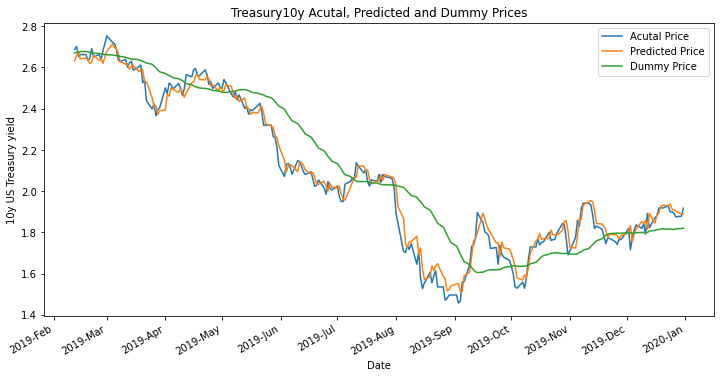

In [19]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

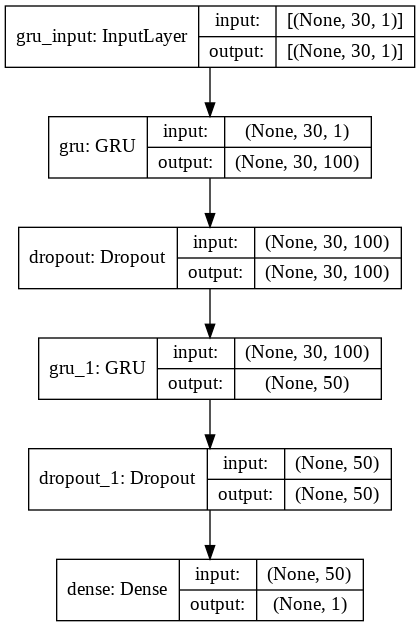

In [20]:
plot_model(model, show_shapes=True, expand_nested=True)

In [21]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.0014508989775100852
RMSE:  0.03809066785329558
MAE:  0.030087983861459763


In [22]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Treasury10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Treasury10y/assets
